In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gamble-dataset/data_v1_preprocessed.csv
/kaggle/input/gamble-dataset/test_v1.csv
/kaggle/input/gamble-dataset/train_v1.csv
/kaggle/input/gamble-dataset/data.csv


In [58]:
!pip install Sastrawi
!pip install transformers
!pip install torch
!pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
import re
import nltk
from nltk.corpus import stopwords
#from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm import tqdm

In [19]:
df = pd.read_csv('/kaggle/input/gamble-dataset/data.csv', sep=';')

In [20]:
df = df[['Comment', 'Label']]

In [21]:
df

,Comment,Label
0,jadi kangen ngebolang di sorong pas PMM kemaren,0
1,Streamer favorit ❤ dan selalu menunggu update ...,1
2,"sketer terus muncul, tiap maen jepek",1
3,Kebelah 2 :),0
4,Jan di spil,0
...,...,...
9292,Bang .. Ikut mendaki bung fiersa atap Negeri t...,0
9293,"Semangat Bosqu , Terbaik ⭐𝗪𝗘𝗧𝗢𝗡𝟴𝟴",1
9294,Penasaran kalo Jefri bener bener ngegambar ses...,0
9295,"@arsep1311 tendang bro gw dukung, sekalian sam...",0


In [28]:
nltk.download('stopwords')

# Initialize stemmer and stopword list
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))  # stopwords bahasa Indonesia

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.strip()  # remove leading/trailing whitespace
    tokens = text.split()  # tokenize
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]  # remove stopwords & lemmatize
    return ' '.join(tokens)

In [30]:
df['Comment'] = df['Comment'].astype(str).apply(preprocess_text)

# modelling

In [5]:
train = pd.read_csv('/kaggle/input/gamble-dataset/train_v1.csv')
test = pd.read_csv('/kaggle/input/gamble-dataset/test_v1.csv')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7196 entries, 0 to 7195
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  7196 non-null   object
 1   Label    7196 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 112.6+ KB


In [8]:
X = train['Comment']
y = train['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [10]:
# Models to evaluate
models = {
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "SGD": SGDClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
}

In [11]:
# Evaluate each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


=== Naive Bayes ===
Accuracy: 0.9625
Confusion Matrix:
 [[1131    4]
 [  50  255]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1135
           1       0.98      0.84      0.90       305

    accuracy                           0.96      1440
   macro avg       0.97      0.92      0.94      1440
weighted avg       0.96      0.96      0.96      1440


=== KNN ===
Accuracy: 0.925
Confusion Matrix:
 [[1132    3]
 [ 105  200]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.95      1135
           1       0.99      0.66      0.79       305

    accuracy                           0.93      1440
   macro avg       0.95      0.83      0.87      1440
weighted avg       0.93      0.93      0.92      1440


=== Decision Tree ===
Accuracy: 0.9534722222222223
Confusion Matrix:
 [[1099   36]
 [  31  274]]
Classification Report:
               pre

In [14]:
# Extract features and labels
X_train = train["Comment"]
y_train = train["Label"]
X_test = test["Comment"]
y_test = test["Label"]

In [15]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [16]:
svm = SVC(kernel="linear", probability=True, random_state=42)
svm.fit(X_train_vec, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [17]:
y_pred = svm.predict(X_test_vec)

In [18]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9888888888888889
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1418
           1       0.98      0.97      0.97       382

    accuracy                           0.99      1800
   macro avg       0.99      0.98      0.98      1800
weighted avg       0.99      0.99      0.99      1800



Confusion Matrix:
 [[1411    7]
 [  13  369]]


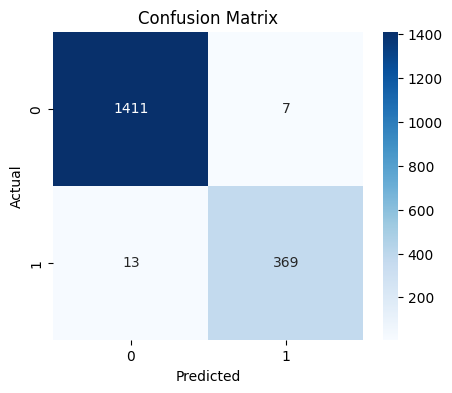

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Print raw confusion matrix
print("Confusion Matrix:\n", cm)

# Optional: Visualize confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()